<a href="https://colab.research.google.com/github/MagnificentTabby/TabbyDiffusion/blob/im2img/Diffusion-Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Re-download Huggingface models list if needed
%%capture
!rm -f /content/gdrive/MyDrive/SD_test/Models.csv
!wget -P /content/gdrive/MyDrive/SD_test https://github.com/MagnificentTabby/TabbyDiffusion/raw/main/Models.csv

In [4]:
%%capture
!pip install diffusers
!pip install torch
!pip install accelerate
!pip install transformers
!pip install PIL
!pip install ipywidgets
!pip install xformers
import os
import csv
import datetime
import accelerate
from PIL import Image
import torch
!from transformers import CLIPTextModel, CLIPTokenizer
!from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler #use different scheduler
from diffusers import (DiffusionPipeline, StableDiffusionImg2ImgPipeline, load_image)
from ipywidgets import widgets
from ipywidgets import Layout

# For GFPGAN
!pip install basicsr
!pip install facexlib
!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan #only need this if we want to enhance the background as well

# Initialise some stuff
dictModels = {}
with open('/content/gdrive/MyDrive/SD_test/Models.csv','r') as f:
  for line in csv.reader(f):
      dictModels[line[0]] = line[1]
widModel = widgets.Dropdown(options=dictModels.keys(), description="Model", disabled=False)
widPrompt = widgets.Text(description="Prompt", disabled=False,layout=Layout(width='90%'))
widNegPrompt = widgets.Text(description="Negative Prompt", disabled=False,layout=Layout(width='90%', description_width='100px'))
widCFG = widgets.BoundedIntText(description="CFG", disabled=False, value=7.5, min=0, max=100, step=0.01)
widSteps = widgets.BoundedIntText(description="Steps", disabled=False, value=30, min=1, max=200, step=1)
widWidth = widgets.BoundedIntText(description="Width", disabled=False, value=512, min=1, step=1, max=2000)
widHeight = widgets.BoundedIntText(description="Height", disabled=False, value=512, min=1, step=1, max=2000)
widSeed = widgets.BoundedIntText(description="Seed", disabled=False, value=0, step=1) #need to set a max value here
widNoImages = widgets.BoundedIntText(description="Batch Size", disabled=False, value=1, step=1) #need to set a max value here
widGFP = widgets.ToggleButton(description="GFPGAN Upscale", value=True, icon='check')
widClipSkip = widgets.BoundedIntText(description="Clip Skip", disabled=False, value=0, min=0, max=50, step=1)
try:
  os.mkdir("/content/gdrive/MyDrive/SD_test/outputs")
except:
  pass

try:
  os.mkdir("/content/gdrive/MyDrive/SD_test/gfpgan")
  !git clone https://github.com/TencentARC/GFPGAN.git /content/gdrive/MyDrive/SD_test/gfpgan
except:
  pass
gfPath = "/content/gdrive/MyDrive/SD_test/gfpgan/inference_gfpgan.py"

In [5]:
display (widModel, widClipSkip)

Dropdown(description='Model', options=('Deliberate-v3', 'Reliberate', 'Dark Sushi'), value='Deliberate-v3')

BoundedIntText(value=0, description='Clip Skip', max=50)

In [7]:
# Set model
%%capture
modPath = dictModels[widModel.value]

pipeline = DiffusionPipeline.from_pretrained(modPath, safety_checker=None, clip_skip=widClipSkip.value)
pipeline.enable_xformers_memory_efficient_attention()
pipeline.to("cuda")
generator = torch.Generator(device="cuda")

# Setup Img2Img reusing components
img2imgPipe = StableDiffusionImg2ImgPipeline(**pipeline.components)

In [8]:
display(widPrompt,widNegPrompt,widCFG,widSteps,widWidth,widHeight,widNoImages,widGFP) #Need to arrange properly

Text(value='', description='Prompt', layout=Layout(width='90%'))

Text(value='', description='Negative Prompt', layout=Layout(width='90%'))

BoundedIntText(value=7, description='CFG', step=0)

BoundedIntText(value=30, description='Steps', max=200, min=1)

BoundedIntText(value=512, description='Width', max=2000, min=1)

BoundedIntText(value=512, description='Height', max=2000, min=1)

BoundedIntText(value=1, description='Batch Size')

ToggleButton(value=True, description='GFPGAN Upscale', icon='check')

In [9]:
# Make output folder
now = datetime.datetime.now().timetuple()[0:5]
pngPath = "/content/gdrive/MyDrive/SD_test/outputs/" + "-".join(str(x) for x in now) + "/"
try:
  os.mkdir(pngPath)
except:
  pass

# Set scheduler
pipeline.scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

for i in range(1, widNoImages.value+1):
  print(i)
  seed = generator.seed() #create random seed
  generator = torch.manual_seed(seed)  # Seed generator to create the inital latent noise
  image = pipeline(prompt = widPrompt.value, negative_prompt=widNegPrompt.value, num_imference_steps=widSteps.value, generator=generator, height=widHeight.value, width=widWidth.value, guidance_scale=widCFG.value).images[0]
  savePath = pngPath + str(seed) + ".png"
  image.save(savePath,"PNG")

if widGFP:
  os.system("python " + gfPath + " -i " + pngPath + " -o " + pngPath)

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

1


  0%|          | 0/50 [00:00<?, ?it/s]

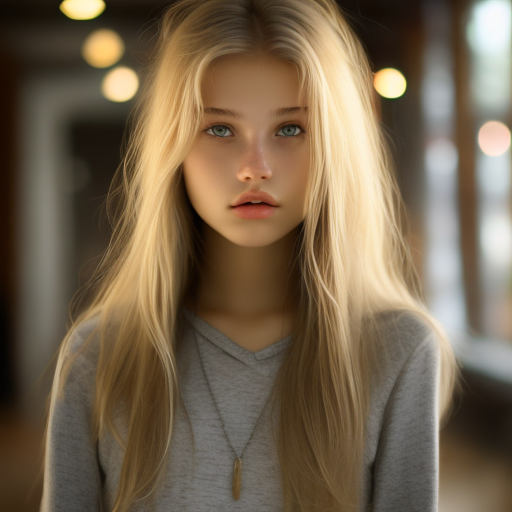

In [17]:
#from diffusers.utils import load_image
testPng = "/content/gdrive/MyDrive/SD_test/outputs/test.png"
img1 = Image.open(testPng)
